In [32]:
#copyright joshuah.rainstar@gmail.com 2025
#MIT with attribution

import math
import copy
from dataclasses import dataclass
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F

class RoPE(nn.Module):
    def __init__(self, dim, max_len=4096):
        super().__init__()
        assert dim % 2 == 0
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        self.register_buffer('cos', freqs.cos())
        self.register_buffer('sin', freqs.sin())

    def forward(self, x):
        # x: (B, *, T, D)
        T = x.shape[-2]
        cos = self.cos[:T, :].unsqueeze(0).unsqueeze(0)
        sin = self.sin[:T, :].unsqueeze(0).unsqueeze(0)

        # Adjust shapes for broadcasting if x has extra dims (like n_branch)
        while cos.ndim < x.ndim:
            cos = cos.unsqueeze(0)
            sin = sin.unsqueeze(0)

        x1 = x[..., 0::2]
        x2 = x[..., 1::2]
        y1 = x1 * cos - x2 * sin
        y2 = x1 * sin + x2 * cos
        return torch.stack((y1, y2), dim=-1).flatten(-2)

class VectorizedConstellationAttention(nn.Module):
    def __init__(
        self,
        config,
        palette_hw: int = 16,
        max_k: int = 15,
        rel_hid: int = 64,
        bias: bool = False,
        use_delta: bool = True,
        delta_dropout: float = 0.1, # NEW: Probability to zero out delta
    ):
        super().__init__()
        assert config.n_embd % 2 == 0
        self.d = config.n_embd
        self.BR = 1
        self.Ph = self.Pw = palette_hw
        self.Kmax = max_k
        self.use_delta = use_delta
        self.delta_dropout = delta_dropout # Store dropout rate

        # Projections
        self.i_proj = nn.Linear(config.n_embd, config.n_embd, bias=bias)
        self.p_proj = nn.Linear(config.n_embd, config.n_embd, bias=bias)

        self.rope = config.rope

        # Persistent palette
        self.palette = nn.Parameter(torch.randn(config.n_embd, self.Ph, self.Pw) * (config.n_embd ** -0.5))

        # Relational MLP
        rel_in = self.Kmax + 1 + (1 if use_delta else 0)
        self.rel_mlp = nn.Sequential(
            nn.Linear(rel_in, rel_hid),
            nn.GELU(),
            nn.Linear(rel_hid, rel_hid),
            nn.GELU(),
        )
        self.coord_head = nn.Linear(rel_hid, 2)
        self.mix_head   = nn.Linear(rel_hid, 1)

        self.Wo = nn.Parameter(torch.randn(1, config.n_embd, config.n_embd) * (config.n_embd ** -0.5))

    def forward(self, x):
        B, T, D = x.shape
        K = self.Kmax
        scale = D ** -0.5
        device = x.device

        # 1) Projections + RoPE
        I = self.i_proj(x).view(B, T, self.BR, D).transpose(1, 2).contiguous()
        P = self.p_proj(x)

        I = self.rope(I)
        P = self.rope(P.unsqueeze(1)).squeeze(1)

        # 2) Pass A: logits + topk
        logits = torch.matmul(I, P.unsqueeze(1).transpose(-1, -2)) * scale

        causal = torch.tril(torch.ones((T, T), device=device, dtype=torch.bool)).view(1, 1, T, T)
        logits = logits.masked_fill(~causal, float("-inf"))

        k_eff = min(K, T)
        topk_val, topk_idx = torch.topk(logits, k=k_eff, dim=-1)

        if k_eff < K:
            pad = K - k_eff
            topk_val = torch.cat([topk_val, topk_val.new_full((B, self.BR, T, pad), float("-inf"))], dim=-1)
            topk_idx = torch.cat([topk_idx, topk_idx.new_zeros((B, self.BR, T, pad))], dim=-1)

        keep = torch.isfinite(topk_val)
        keep_f = keep.float()

        # Fallback for empty rows
        all_bad = ~keep.any(dim=-1, keepdim=True)
        if all_bad.any():
            t_idx = torch.arange(T, device=device).view(1, 1, T, 1).expand(B, self.BR, T, 1)
            topk_idx = torch.where(all_bad, t_idx, topk_idx)
            keep = torch.isfinite(topk_val)
            keep_f = keep.float()

        # 3) Gather features
        b_idx = torch.arange(B, device=device).view(B, 1, 1, 1)
        P_sel = P[b_idx, topk_idx]
        P_sel_norm = F.normalize(P_sel, dim=-1) * keep_f.unsqueeze(-1)
        I_norm = F.normalize(I, dim=-1).unsqueeze(3)

        feat_a = (I_norm * P_sel_norm).sum(dim=-1).clamp(-1.0, 1.0) * keep_f
        G = torch.matmul(P_sel_norm, P_sel_norm.transpose(-1, -2)).clamp(-1.0, 1.0)
        G = G * keep_f.unsqueeze(-1) * keep_f.unsqueeze(-2)

        feats = [G, feat_a.unsqueeze(-1)]

        if self.use_delta:
            t_range = torch.arange(T, device=device).view(1, 1, T, 1)
            delta = (t_range - topk_idx).float().clamp_min(0.0) / max(1.0, float(T))
            delta = delta * keep_f

            # --- NEW: Delta Dropout (Training only) ---
            if self.training and self.delta_dropout > 0:
                # Create a mask: 1 with prob (1-p), 0 with prob p
                mask = torch.bernoulli(torch.full_like(delta, 1.0 - self.delta_dropout))
                delta = delta * mask

            feats.append(delta.unsqueeze(-1))

        rel_input = torch.cat(feats, dim=-1)

        # 4) MLP
        h = self.rel_mlp(rel_input)
        z = torch.tanh(self.coord_head(h))
        mix_logits = self.mix_head(h).squeeze(-1).masked_fill(~keep, float("-inf"))
        w = torch.nan_to_num(torch.softmax(mix_logits, dim=-1), nan=0.0)

        # 5) Sample
        batch_pal = self.palette.unsqueeze(0).expand(B, -1, -1, -1)
        grid = z.reshape(B, T, K, 2)
        samples = F.grid_sample(batch_pal, grid, mode="bilinear", padding_mode="border", align_corners=True)

        samples = samples.view(B, 1, D, T, K).permute(0, 1, 3, 4, 2)
        V_out = (samples * w.unsqueeze(-1)).sum(dim=3)
        y = torch.einsum("nrtd,rdm->nrtm", V_out, self.Wo).mean(dim=1)

        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear( config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.scale = math.pi / math.sqrt(3.0)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = x * torch.sigmoid(self.scale * x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_branch = 4
        self.block_size = config.block_size
        self.n_sinks = getattr(config, 'n_sinks', 4) # Default to 4 sink tokens

        # Projections: Q and V produce NB branches, K is shared
        self.q_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.k_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_proj = nn.Linear(config.n_embd, config.n_embd * self.n_branch, bias=config.bias)
        self.o_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Learnable sink tokens for K and V
        # K sink is (1, 1, n_sinks, C) to broadcast across batch and branches
        self.k_sink = nn.Parameter(torch.zeros(1, 1, self.n_sinks, config.n_embd))
        # V sink is (1, n_branch, n_sinks, C) as V is branched
        self.v_sink = nn.Parameter(torch.zeros(1, self.n_branch, self.n_sinks, config.n_embd))

        self.register_buffer("mask", torch.tril(torch.ones(config.block_size + self.n_sinks, config.block_size + self.n_sinks))
                             .view(1, 1, config.block_size + self.n_sinks, config.block_size + self.n_sinks))

        self.rope = config.rope
        self.attn_drop = nn.Dropout(config.dropout)
        
    def forward(self, a, x):
        B, T, C = x.shape
        NB = self.n_branch
        NS = self.n_sinks

        # Project and reshape: (B, T, NB, C) -> (B, NB, T, C)
        q = self.q_proj(a).view(B, T, NB, C).transpose(1, 2)
        v_orig = self.v_proj(a).view(B, T, NB, C).transpose(1, 2)
        # K has no branch dimension initially: (B, T, C) -> (B, 1, T, C)
        k_orig = self.k_proj(x).view(B, T, 1, C).transpose(1, 2)

        # Apply RoPE to projected sequences before adding sinks
        q, k_orig = self.rope(q), self.rope(k_orig)

        # Prepend Sinks:
        # K sinks: (1, 1, NS, C) -> (B, 1, NS, C)
        k = torch.cat([self.k_sink.expand(B, -1, -1, -1), k_orig], dim=2)
        # V sinks: (1, NB, NS, C) -> (B, NB, NS, C)
        v = torch.cat([self.v_sink.expand(B, -1, -1, -1), v_orig], dim=2)

        # Raw scores: (B, NB, T, C) @ (B, 1, C, T + NS) -> (B, NB, T, T + NS)
        att = (q @ k.transpose(-2, -1)) / math.sqrt(C)

        # Causal Masking: The mask must account for the T + NS dimension
        # Sinks are always visible, so the first NS columns are 1s
        full_T = T + NS
        mask = self.mask[:, :, NS:full_T, :full_T]
        att = att.masked_fill(mask == 0, float("-inf"))

        # Branch Routing Logic (Softmax across the NB dimension)
        soft_probs = F.softmax(att, dim=1)
        soft_probs = torch.nan_to_num(soft_probs, nan=0.0)

        # Straight-Through Estimator (STE)
        with torch.no_grad():
            max_val = soft_probs.max(dim=1, keepdim=True)[0]
            hard_mask = (soft_probs == max_val).float()

        route_mask = (hard_mask - soft_probs).detach() + soft_probs

        # Temporal Attention (Softmax across the T + NS dimension)
        att_max, _ = att.max(dim=1)
        attn_probs = F.softmax(att_max, dim=-1)

        # Composition
        combined_weights = attn_probs.unsqueeze(1) * route_mask

        # Weighted sum: (B, NB, T, T + NS) @ (B, NB, T + NS, C) -> (B, NB, T, C)
        y = (combined_weights @ v).sum(dim=1) 

        out = self.o_proj(y)
        return out



def norm(x):
    return F.rms_norm(x, (x.size(-1),))


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.think = VectorizedConstellationAttention(config)
        self.attn = Attention(config)
        self.mlp = MLP(config)
        self.mlp2 = MLP(config)


    def forward(self, x):
        B, T, C = x.shape
        q = self.think(norm(x))
        a = q + self.mlp(norm(q))
        u = x + self.attn(norm(a), norm(x))
        u = u + self.mlp2(norm(u)) #reconstructive shift
        steps = torch.arange(1, x.size(1) + 1, device=x.device).view(1, -1, 1)
        running_mean = torch.cumsum(norm(a), dim=1) / steps
        u = u + running_mean
        return u

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 1
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    n_branch: int = 4 # Number of branches in Attention
    rope: nn.Module = None


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        # Base noise seed (learned) for map generation
        self.rope = RoPE(config.n_embd, max_len=config.block_size)
        self.config.rope = self.rope

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(self.config) for _ in range(config.n_layer)]),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        return n_params


    def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()
        x = self.transformer.wte(idx) # token

        # forward the GPT model itself
        for block in self.transformer.h:
            x  = block(x)
        B, T, C = x.shape

        x = norm(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss




In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [3]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [33]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 512
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=4,
    n_embd=128,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)
model = GPT(config)
model = torch.compile(model)
model = model.to(device)


number of parameters: 2.09M


In [34]:
#MIT with attribution
import numpy as np
import torch
import torch.nn.functional as F
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
import io
import math
import time

class FastMatrixDashboard:
    def __init__(self, batch_size, seq_len, itos=None, cell_w=10, cell_h=16, target_fps=20):
        """
        High-Performance Vectorized Dashboard by joshuah rainstar, {your name here if you make edits}
        joshuah.rainstar@gmail.com
        --your email here--
        """
        self.target_cells = batch_size * seq_len
        self.itos = itos

        # --- 1. Geometry ---
        self.rows = int(math.sqrt(self.target_cells / 5))
        self.cols = int(np.ceil(self.target_cells / self.rows))
        self.n_cells = self.rows * self.cols

        self.cell_w = cell_w
        self.cell_h = cell_h
        self.width = self.cols * self.cell_w
        self.height = self.rows * self.cell_h
        self.stats_height = 40
        self.total_height = self.height + self.stats_height

        # --- 2. Font & Atlas Setup (The Speedup) ---
        # We render all chars to a numpy bank once.
        try:
            self.font = ImageFont.truetype("DejaVuSansMono.ttf", 11)
        except:
            self.font = ImageFont.load_default()

        # Create Atlas: Shape (256, H, W) - Pre-render ASCII 0-255
        # We use a mask: 1.0 where text is, 0.0 where background is.
        self.atlas = np.zeros((256, self.cell_h, self.cell_w), dtype=np.float32)

        temp_img = Image.new("L", (self.cell_w, self.cell_h))
        temp_draw = ImageDraw.Draw(temp_img)

        for i in range(256):
            char = chr(i) if 32 <= i <= 126 else "?"
            # Custom replacements for visibility
            if i == 10: char = "¶"  # Newline
            if i == 9:  char = "→"  # Tab
            if i == 32: char = "·"  # Space

            temp_draw.rectangle((0, 0, self.cell_w, self.cell_h), fill=0)
            temp_draw.text((0, 0), char, font=self.font, fill=255)
            # Normalize to 0..1
            self.atlas[i] = np.array(temp_img, dtype=np.float32) / 255.0

        # --- 3. Token Lookup Optimization ---
        # Map vocab IDs -> Atlas IDs (0-255)
        if self.itos:
            vocab_size = max(self.itos.keys()) + 1
            self.vocab_map = np.zeros(vocab_size, dtype=int)
            for k, v in self.itos.items():
                # Take first char ord or ?
                char_code = ord(v[0]) if len(v) > 0 else 63
                # Ensure range
                if not (0 <= char_code <= 255): char_code = 63
                self.vocab_map[k] = char_code
        else:
            self.vocab_map = None # Direct mapping

        # --- 4. Simulation State (Numpy Arrays) ---
        # Instead of a list of chars, we store indices and colors
        self.state_indices = np.full(self.n_cells, 32, dtype=int) # 32 = Space
        self.state_colors = np.zeros((self.n_cells, 3), dtype=np.float32) + 40.0
        self.freshness = np.zeros(self.n_cells, dtype=np.float32)

        self.ewma_loss = None
        self.step = 0
        self.last_render_time = 0
        self.min_render_interval = 1.0 / target_fps

        # --- 5. Widget ---
        self.out_widget = widgets.Image(format='png', width=self.width, height=self.total_height)
        self.layout = widgets.VBox([self.out_widget])

    def render(self):
        display(self.layout)

    def update(self, yb, logits, loss_val):
        self.step += 1

        # Throttling: Don't render if we just rendered (keeps training loop fast)
        now = time.time()
        if now - self.last_render_time < self.min_render_interval:
            return
        self.last_render_time = now

        # --- 1. Tensor Ops (Fast) ---
        with torch.no_grad():
            probs = F.softmax(logits, dim=-1)
            p_max, preds = torch.max(probs, dim=-1)

            p_max = p_max.cpu().numpy().flatten()
            preds = preds.cpu().numpy().flatten()
            targets = yb.cpu().numpy().flatten()

        limit = min(len(p_max), self.n_cells)

        # --- 2. Vectorized Freshness Logic ---
        # Note: Operations are done on arrays, not loops
        is_correct = (preds[:limit] == targets[:limit]).astype(np.float32)
        self.freshness *= 0.92

        current_fresh = self.freshness[:limit]
        new_conf = p_max[:limit]

        # Mask: where to update
        update_mask = (new_conf > current_fresh) | (current_fresh < 0.10)

        # Update freshness
        self.freshness[:limit] = np.where(update_mask, new_conf, current_fresh)

        if not np.any(update_mask):
            return # Nothing visual changed significantly

        # --- 3. Vectorized Color & Char Mapping ---
        # Create target colors
        vals = new_conf * 255.0
        vals = np.maximum(50.0, vals)

        # R, G, B vectors
        r = (is_correct[:limit] * (vals * 0.5) + (1 - is_correct[:limit]) * vals)
        g = (is_correct[:limit] * vals + (1 - is_correct[:limit]) * (vals * 0.5))
        b = (is_correct[:limit] * (vals * 0.25))

        new_colors = np.stack([r, g, b], axis=1) # (limit, 3)

        # Map tokens to atlas indices
        if self.vocab_map is not None:
            # Safe lookup handling bounds
            safe_preds = np.clip(preds[:limit], 0, len(self.vocab_map)-1)
            safe_targets = np.clip(targets[:limit], 0, len(self.vocab_map)-1)

            token_indices = self.vocab_map[safe_preds]
            target_indices = self.vocab_map[safe_targets]

            # Fallback logic (vectorized): if OOV (mapped to '?'), use target
            # Assuming '?' is index 63.
            # A better heuristic for "OOV" in this optimized version might just be
            # relying on the vocab_map.
            # If strict OOV check is needed, we check if preds not in self.itos.
            # For speed, we trust the vocab_map handles the fallback.
        else:
            # If no itos, use raw ASCII
            token_indices = np.clip(preds[:limit], 32, 126)

        # Update state buffers
        self.state_indices[:limit] = np.where(update_mask, token_indices, self.state_indices[:limit])
        self.state_colors[:limit] = np.where(update_mask[:, None], new_colors, self.state_colors[:limit])

        # --- 4. Image Composition (The Heavy Lifting moved to Numpy) ---
        # 1. Retrieve Masks: (N, H, W)
        masks = self.atlas[self.state_indices]

        # 2. Apply Colors: (N, H, W, 3)
        # Broadcast: (N, H, W) -> (N, H, W, 1) * (N, 1, 1, 3)
        grid_pixels = masks[..., None] * self.state_colors[:, None, None, :]

        # 3. Reshape to Grid Image (Rows, Cols, H, W, 3)
        # Pad if necessary to fill grid
        if grid_pixels.shape[0] < self.n_cells:
            padding = np.zeros((self.n_cells - grid_pixels.shape[0], self.cell_h, self.cell_w, 3))
            grid_pixels = np.concatenate([grid_pixels, padding], axis=0)

        grid_reshaped = grid_pixels.reshape(self.rows, self.cols, self.cell_h, self.cell_w, 3)

        # 4. Transpose to (Rows, H, Cols, W, 3) -> (Height, Width, 3)
        final_grid = grid_reshaped.transpose(0, 2, 1, 3, 4).reshape(self.height, self.width, 3)

        # Cast to uint8
        final_img_arr = np.clip(final_grid, 0, 255).astype(np.uint8)

        # --- 5. Stats Bar (PIL is fine here, it's small) ---
        # We create the stats bar separately and stack it
        if self.ewma_loss is None: self.ewma_loss = loss_val
        else: self.ewma_loss = 0.95 * self.ewma_loss + 0.05 * loss_val
        acc = np.mean(is_correct)

        stats_img = Image.new("RGB", (self.width, self.stats_height), (20, 20, 20))
        draw = ImageDraw.Draw(stats_img)
        # Stats Text
        draw.text((10, 10), f"STEP: {self.step}", font=self.font, fill=(200, 200, 200))
        draw.text((100, 10), f"LOSS: {loss_val:.4f}", font=self.font, fill=(255, 100, 100))
        draw.text((220, 10), f"EWMA: {self.ewma_loss:.4f}", font=self.font, fill=(255, 255, 0))
        draw.text((340, 10), f"ACC: {acc:.1%}", font=self.font, fill=(0, 255, 0))

        # --- 6. Final Combine & Compress ---
        # Convert Stats to numpy
        stats_arr = np.array(stats_img)

        # Vertical Stack
        full_frame = np.vstack((stats_arr, final_img_arr))

        # Convert to PNG using low compression for speed
        # PIL.Image.fromarray is zero-copy for uint8 usually
        img_obj = Image.fromarray(full_frame)

        with io.BytesIO() as output:
            # compress_level=1 is much faster than default (6)
            img_obj.save(output, format="PNG", compress_level=1)
            self.out_widget.value = output.getvalue()

# Example Usage:
dashboard = FastMatrixDashboard(batch_size, block_size, itos=itos)
dashboard.render()
# In loop: dashboard.update(yb, logits, loss.item())

In [35]:
import sys
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []

def train_epoch():
    model.train()
    total_loss = 0
    # We use enumerate to get a step counter for the in-place display
    for i, (xb, yb) in enumerate(train_loader):
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()

          val = loss.item()
          total_loss += val
          losses.append(val)
          dashboard.update(yb, logits, loss.item())
          # Implementation of in-place writing:
          # \r moves cursor to start of line.
          # end="" prevents creating a new line.
          # We format to 5 decimal places to keep the string length relatively stable.
          print(f"\rBatch {i+1} | Instant Loss: {val:.5f}", end="")

    # Print a newline at the end of the epoch so the final summary
    # doesn't overwrite the last batch status.
    print()
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    # This will print clearly on its own line after the batch loop finishes
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

/usr/local/lib/python3.12/site-packages/torch/_inductor/lowering.py:7095: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/site-packages/torch/_inductor/lowering.py:7095: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


Batch 2308 | Instant Loss: 1.41485

KeyboardInterrupt: 

In [54]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    # This will print clearly on its own line after the batch loop finishes
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

Batch 3510 | Instant Loss: 1.23882

KeyboardInterrupt: 

In [56]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=8192,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
Yet worse, pardels a pittemnity longer:
I here, for God. Let it prove issper.
Boot you the butter will a piteous lord,
Have condemner and you would holp to-mard
You Angelo:
But can make my traitor, as I prithee, to the duty,
'Which thou revengean of a business,
I with Lewis Judashering take away thy hand, whom.
Farewell, I make the word.

LADY CAPULET:
Were come to death that aught it how thee.

BENVOLIO:
Never money: little muset!

Provost:
O Deeper:
Thear, swear to and Gaunt till;
Where a valour'd, and man turn Plantageness. Here any thine
A sinferment love miew dead to commend
Thee redeem'd and to conclude of his noble time,
Put to-dare to pollow ourself, that ourself.

CLIFFORD:
That's by heir pale
Sicing as my us bound.

My love, me! 'Scalled? do you make, one a banish:
Therefore, give chance an ummour of tread:
You take abroad! Do my commors of this world;
And make him tell, my lord. You call.

LUCIO:
There impeak.

ISABELLA:
Pardon me! O n

In [57]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.00001
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
What is the seat, and there is the seat,
And there it is the seat, and there it is the duke.

KING RICHARD III:
What is the duke of the seat, and the duke,
And therefore the seat, and the seates and me.

KING RICHARD III:
What is the deadly and the seat the seat,
And there the seat that would come to the seas.

KING RICHARD III:
Then thou art please you to the seat,
And therefore the seat to the seat, and they
with the seat that would have the seat to the sea
The sea the seat to the seat that would death,
And therefore the seat that we did so much thee,
And therefore the seat to the seat, and they
with the secret of the seat that would death,
And therefore the search the seat the sea,
And therefore the seat, and the seates and seather,
And therefore the seat to the seat, and the sea
The sea the seat that would have the seas,
And therefore the seated than the seat,
And therefore the seat, and the seates and so.

Second Murderer:
What is the deadly

In [58]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)


with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=model.config.block_size,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=3.0
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET: Agey!t.'
YSIGrs, whe's, mwOH !ray;
Fond kmeccutas. VoI. Nay? ?waxes.
ber-ms, earhS,--ststai!; vILDILUGY, callom.'d PZdricm?
It with your f-stany,ncD,Wedrkmentaf$;
MonjiDAm?
:lneLNEY:
EttoY yover bublly
Iadiym MyrvLY-ofd  Riveokp I rascoc,-
Comphele' weom LicuTW&Xt; Trace, &Bp
-pkse-titmaliGWlb!, &enqw
MRCCulcIy?-
PWcdra s't,
AtOMT&INIUveSep .
IunLO,E:sBdLfvil-groughip jelipwved!

MOPC Pmyixt
Piat.
LidLA:
AwhZy PoCqb$LFueO;yvreII&Sovb
3MZc-pRckvTEmerby, rruru.
Mird, Itveap: Alheuad; but vlrolp
LLse.
Hootmx

SLOMA:
Orieve:
OhLYrrco!TR;fqucck?
'igle?
3envior; CbrldIU!! Tited venttiKlS;
Let's afcafUs ok: alm',,Ctage, wouldgsHqu?
If,
ThlAKSCINQOdmY.; 'We,Bkige-fa? naxtept lurt;-
Must, anE;fanhee,.d
SOApiaff! 'B. Arrslp splilext
rjou you:p 'M rhaix'Rs.. CoumforYClamen'?Ygy: valugar;
ErmoON:
HebryiD, smooitrn may?
Ceggo:' pligpt.

STftgni: saunif AUla,!
ALcemew?: O expein-loat ? I LoXFv?
Kmtid?
Aw, j '3
Rdow?Nl queen;
Eheah.

TRME,ETER, boyy toaraGomf, 

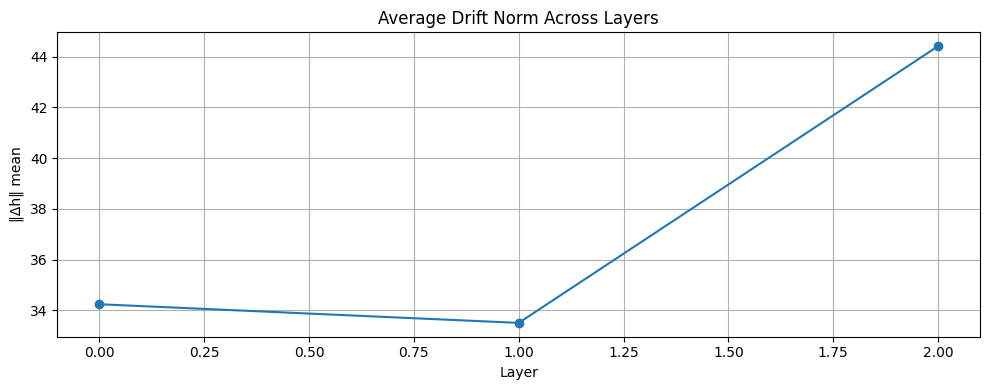

Jacobian rank (final token, projected): 66


In [59]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
     def forward(self, idx, targets=None):
        device = idx.device
        b, T = idx.size()

        # forward the GPT model itself
        x = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx
    # forward the GPT model itself


    # token + pos emb
    x = model.transformer.wte(tok)
    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        x = m=norm(x)
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [60]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, x.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [23]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


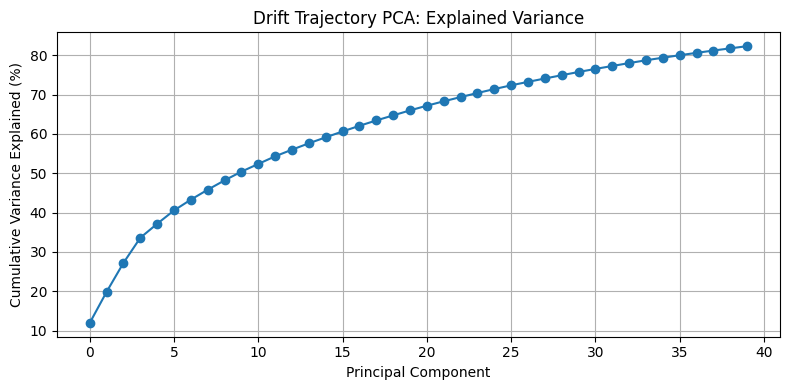

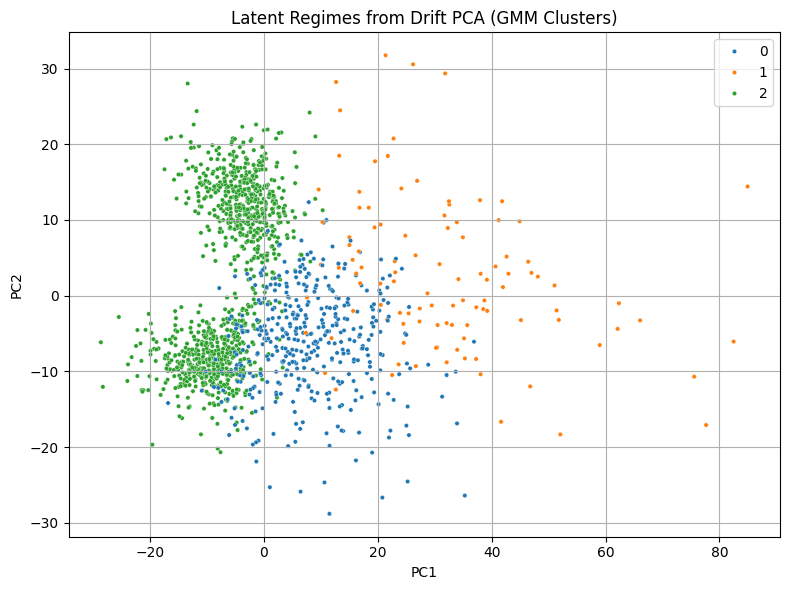

In [66]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=3)
plot_gmm_clusters(proj, labels)


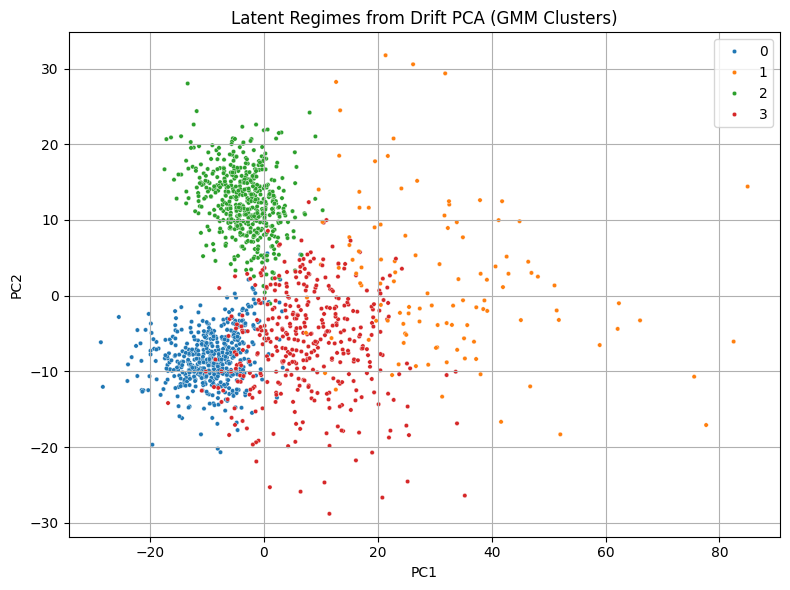

In [68]:

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)

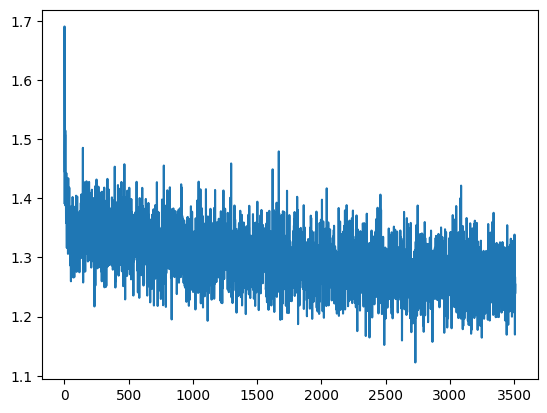

In [69]:
plt.plot(losses)

[Baseline] Val loss: 1.6466

--- Per-Layer Ablation Report ---
Ablate Layer  0: Loss = 1.5866 | Δ = -0.0600
Ablate Layer  1: Loss = 1.5546 | Δ = -0.0919
Ablate Layer  2: Loss = 1.5463 | Δ = -0.1003
Ablate Layer  3: Loss = 1.5818 | Δ = -0.0648


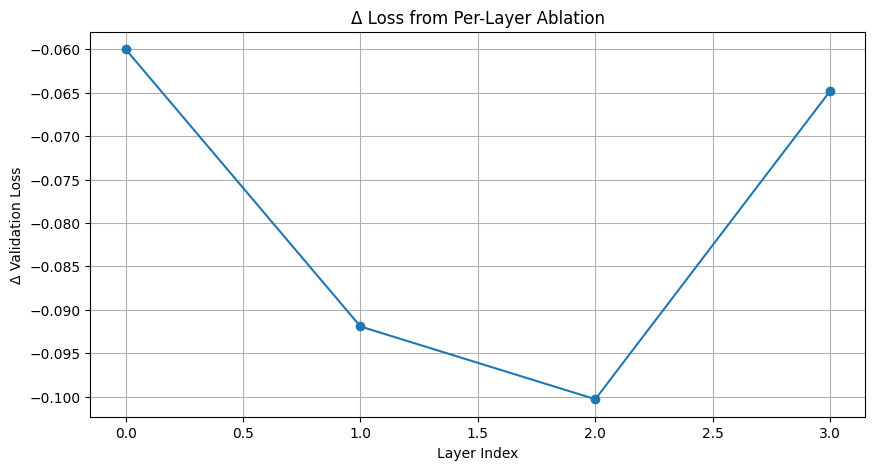

In [70]:
import matplotlib.pyplot as plt
from contextlib import contextmanager
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

# ==============================
# 🔁 LAYER ABLATION LOGIC BLOCK
# =============================

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = model.config.block_size
batch_size = 1
# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.total = len(self.data) - block_size - 1

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)
        for i in range(self.batch_size):
            start = np.random.randint(0, self.total // self.block_size) * self.block_size
            X[i] = self.data[start : start + self.block_size]
            Y[i] = self.data[start + 1 : start + 1 + self.block_size]
        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )

val_dataset = GPUBatchDataset(val_ids, block_size, batch_size=1, device=device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
losses = []
@contextmanager
def layer_ablation_context(model, layers_to_ablate):
    """Context manager that safely ablates selected layers by overriding their .forward."""
    original_forwards = [block.forward for block in model.transformer.h]

    def make_ablation_forward(index, original_fn):
        def ablated_forward(x):
            out = original_fn(x)
            return out
        return ablated_forward

    try:
        for i, block in enumerate(model.transformer.h):
            if i in layers_to_ablate:
                model.transformer.h[i].forward = make_ablation_forward(i, original_forwards[i])
        yield
    finally:
        # Always restore the original forwards
        for i, block in enumerate(model.transformer.h):
            model.transformer.h[i].forward = original_forwards[i]

@torch.no_grad()
def eval_epoch(max_batches=50):
    model.eval()
    total_loss = 0
    for i, (xb, yb) in enumerate(val_loader):
        if i >= max_batches:
            break
        xb, yb = xb[0], yb[0]
        logits, _ = model(xb, yb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B * T, V),
                                yb.view(B * T)).item()
    return total_loss / max_batches

# ---- Evaluate baseline without any ablation ----
with layer_ablation_context(model, layers_to_ablate=set()):
    baseline_val_loss = eval_epoch()
print(f"[Baseline] Val loss: {baseline_val_loss:.4f}")

# ---- Run per-layer ablation safely ----
print("\n--- Per-Layer Ablation Report ---")
results = []
for i in range(model.config.n_layer):
    with layer_ablation_context(model, layers_to_ablate={i}):
        loss = eval_epoch()
    delta = loss - baseline_val_loss
    results.append((i, loss, delta))
    print(f"Ablate Layer {i:2d}: Loss = {loss:.4f} | Δ = {delta:.4f}")

# ---- Plotting ----
layer_ids = [i for i, _, _ in results]
delta_vals = [delta for _, _, delta in results]

plt.figure(figsize=(10, 5))
plt.plot(layer_ids, delta_vals, marker='o')
plt.title("Δ Loss from Per-Layer Ablation")
plt.xlabel("Layer Index")
plt.ylabel("Δ Validation Loss")
plt.grid(True)
plt.show()


In [52]:
PATH = "model_weights.pth"

# Save only the model's learned parameters
torch.save(model.state_dict(), PATH)